# Seasonal Catalog Mix Predictor
Goal: Predict the ideal catalog mix based on past seasonal purchasing trends.  

Riekena, John SIM3 Task2.c  
July, 2025

## Import data

In [2]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import Dependencies (Libraries)

In [3]:
# import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn sub-libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# sklearn model(s)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

#import the original csv
sales_data = pd.read_csv("/content/gdrive/My Drive/SCMP Folder/sales_data.csv")
sales_data.head()

,Year,Month,Season,Category
0,2021,May,Spring,Footwear
1,2023,July,Summer,Clothing
2,2024,March,Spring,Clothing
3,2024,June,Summer,Clothing
4,2021,October,Fall,Footwear


## Explore

In [4]:
#check the basic stats
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Year      10000 non-null  int64 
 1   Month     10000 non-null  object
 2   Season    10000 non-null  object
 3   Category  10000 non-null  object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


In [5]:
#check out the dataframe itself
sales_data

,Year,Month,Season,Category
0,2021,May,Spring,Footwear
1,2023,July,Summer,Clothing
2,2024,March,Spring,Clothing
3,2024,June,Summer,Clothing
4,2021,October,Fall,Footwear
...,...,...,...,...
9995,2021,September,Fall,Outerwear
9996,2022,September,Fall,Footwear
9997,2024,July,Summer,Footwear
9998,2021,August,Summer,Outerwear


In [6]:
sales_data['Month'].value_counts()

,count
Month,
September,1205
November,1195
October,1194
March,1049
May,992
April,988
July,671
June,655
August,644


In [7]:
#convert months to numbers
month_to_nums = {'January': 1, 'February': 2, 'March': 3,
                 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9,
                 'October': 10, 'November': 11, 'December': 12}

sales_data['Month'] = sales_data['Month'].map(month_to_nums)

sales_data

,Year,Month,Season,Category
0,2021,5,Spring,Footwear
1,2023,7,Summer,Clothing
2,2024,3,Spring,Clothing
3,2024,6,Summer,Clothing
4,2021,10,Fall,Footwear
...,...,...,...,...
9995,2021,9,Fall,Outerwear
9996,2022,9,Fall,Footwear
9997,2024,7,Summer,Footwear
9998,2021,8,Summer,Outerwear


In [8]:
#no nulls found, check for NaNs

print("Check NaNs")
print(sales_data.isna().sum())
print("\n 0 = no NaNs")

Check NaNs
Year        0
Month       0
Season      0
Category    0
dtype: int64

 0 = no NaNs


In [9]:
#see the basic stats
sales_data.describe(include="all")

,Year,Month,Season,Category
count,10000.000000,10000.00000,10000,10000
unique,NaN,NaN,4,4
top,NaN,NaN,Fall,Clothing
freq,NaN,NaN,3594,4359
mean,2022.208200,6.92140,NaN,NaN
std,1.357511,3.25424,NaN,NaN
min,2020.000000,1.00000,NaN,NaN
25%,2021.000000,4.00000,NaN,NaN
50%,2022.000000,7.00000,NaN,NaN
75%,2023.000000,10.00000,NaN,NaN


In [10]:
#check category sales by season
sales_data.groupby("Season")["Category"].value_counts()

Season  Category   
Fall    Clothing       1427
        Outerwear       933
        Accessories     868
        Footwear        366
Spring  Clothing       1420
        Accessories     765
        Footwear        614
        Outerwear       230
Summer  Clothing        892
        Accessories     504
        Footwear        329
        Outerwear       245
Winter  Clothing        620
        Accessories     319
        Outerwear       288
        Footwear        180
Name: count, dtype: int64

In [11]:
#see categories by year
sales_data.groupby("Year")["Category"].value_counts()


Year  Category   
2020  Clothing       636
      Accessories    353
      Outerwear      219
      Footwear       217
2021  Clothing       811
      Accessories    452
      Outerwear      327
      Footwear       271
2022  Clothing       963
      Accessories    538
      Outerwear      363
      Footwear       310
2023  Clothing       979
      Accessories    558
      Outerwear      393
      Footwear       357
2024  Clothing       970
      Accessories    555
      Outerwear      394
      Footwear       334
Name: count, dtype: int64

###VISUALIZATION 1:  
A heatmap of category sales by month.

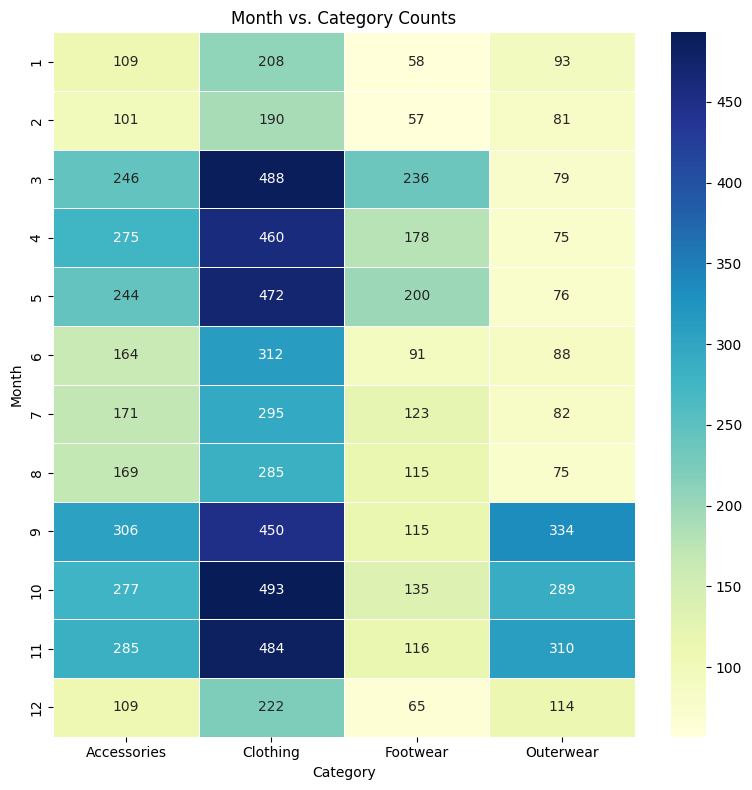

In [12]:
category_by_season_heatmap = pd.crosstab(sales_data['Month'], sales_data['Category'])

plt.figure(figsize=(8, 8))
sns.heatmap(category_by_season_heatmap, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title('Month vs. Category Counts')
plt.xlabel('Category')
plt.ylabel('Month')
plt.tight_layout()

plt.show()

In [13]:
#find total sales by season
sales_counts_by_season = sales_data.value_counts('Season')
sales_counts_by_season

,count
Season,
Fall,3594
Spring,3029
Summer,1970
Winter,1407


In [14]:
#make dataframes for each season(boolean indexing)
fall_sales = sales_data[sales_data['Season'] == 'Fall']
summer_sales = sales_data[sales_data['Season'] == 'Summer']
spring_sales = sales_data[sales_data['Season'] == 'Spring']
winter_sales = sales_data[sales_data['Season'] == 'Winter']

#double check one
summer_sales

,Year,Month,Season,Category
1,2023,7,Summer,Clothing
3,2024,6,Summer,Clothing
5,2024,6,Summer,Accessories
7,2023,7,Summer,Clothing
8,2023,6,Summer,Clothing
...,...,...,...,...
9980,2021,6,Summer,Accessories
9984,2023,7,Summer,Accessories
9992,2022,6,Summer,Accessories
9997,2024,7,Summer,Footwear


###VISUALIZATION 2:
Baseline Category sales mix by percentages.

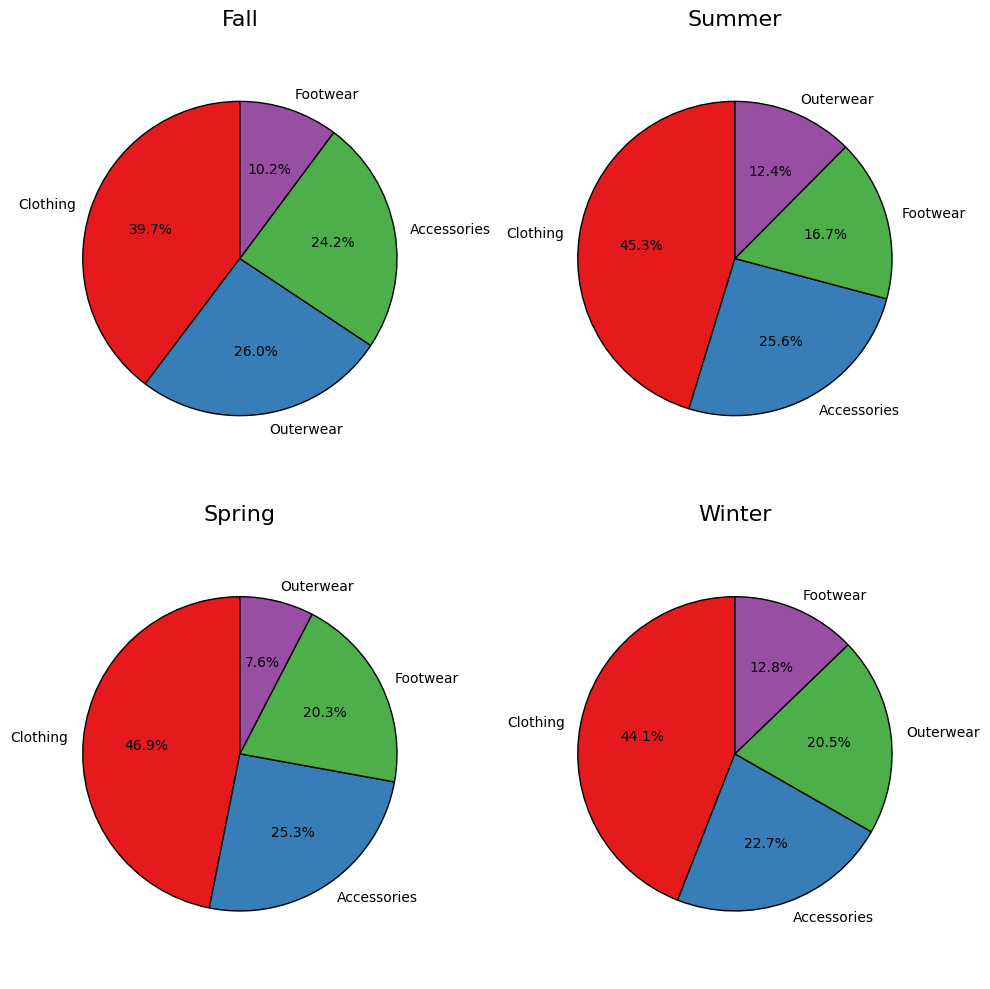

In [15]:
#use these to plot pie charts of the category percentages of each season
##counts
fall_cat_counts = fall_sales['Category'].value_counts()
summer_cat_counts = summer_sales['Category'].value_counts()
spring_cat_counts = spring_sales['Category'].value_counts()
winter_cat_counts = winter_sales['Category'].value_counts()

pie_data_list = [
    (fall_cat_counts, 'Fall'),
    (summer_cat_counts, 'Summer'),
    (spring_cat_counts, 'Spring'),
    (winter_cat_counts, 'Winter')
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()
#iterate instead of rewriting
for i, (counts, title) in enumerate(pie_data_list):
  ax = axes[i]
  colors = sns.color_palette("Set1", n_colors = len(counts))

  ax.pie(
      counts,
      labels = counts.index,
      autopct = "%1.1f%%",
      startangle = 90,
      colors = colors,
      wedgeprops = {"edgecolor": "black"}
    )
  ax.set_title(title, fontsize = 16)
  ax.axis("equal")

plt.tight_layout()
plt.show()

## Transform  


### Notes on data transformation

Use month instead of Season for more datapoints

Steps:  
* Raw Data
* Aggregate Sales by Year, Month, Category
* Calculate Sales per Year and Month
* Join and Calculate Percentages
* Pivot Categories into Columns
* Create a Target Column of the Ratio

GOAL:  
Starting df:  
' Year Month Season Category '  
Ending df:  
' Year Month Season Accessories% Clothing% Footwear% Outerwear% '

In [16]:
#raw data (checking the sales_data again)
sales_data

,Year,Month,Season,Category
0,2021,5,Spring,Footwear
1,2023,7,Summer,Clothing
2,2024,3,Spring,Clothing
3,2024,6,Summer,Clothing
4,2021,10,Fall,Footwear
...,...,...,...,...
9995,2021,9,Fall,Outerwear
9996,2022,9,Fall,Footwear
9997,2024,7,Summer,Footwear
9998,2021,8,Summer,Outerwear


In [17]:
#agg sales by year, month, category
category_sales = sales_data.groupby(['Year', 'Month', 'Category']).size().reset_index(name='Category Sales')

category_sales.head()

,Year,Month,Category,Category Sales
0,2020,1,Accessories,10
1,2020,1,Clothing,29
2,2020,1,Footwear,11
3,2020,1,Outerwear,16
4,2020,2,Accessories,15


In [18]:
#calc sales by year and month
monthly_sales = category_sales.groupby(['Year', 'Month'])['Category Sales'].sum().reset_index()
monthly_sales.rename(columns={'Category Sales': 'Total Monthly Sales'}, inplace = True)

monthly_sales.head()

,Year,Month,Total Monthly Sales
0,2020,1,66
1,2020,2,68
2,2020,3,162
3,2020,4,138
4,2020,5,136


In [19]:
#join the two and calc percentages
category_monthly_merge = pd.merge(category_sales, monthly_sales, on=['Year', 'Month'])
category_monthly_merge['Category Percent'] = (category_monthly_merge['Category Sales'] / category_monthly_merge['Total Monthly Sales'] * 100).round(4)

category_monthly_merge

,Year,Month,Category,Category Sales,Total Monthly Sales,Category Percent
0,2020,1,Accessories,10,66,15.1515
1,2020,1,Clothing,29,66,43.9394
2,2020,1,Footwear,11,66,16.6667
3,2020,1,Outerwear,16,66,24.2424
4,2020,2,Accessories,15,68,22.0588
...,...,...,...,...,...,...
235,2024,11,Outerwear,70,278,25.1799
236,2024,12,Accessories,21,112,18.7500
237,2024,12,Clothing,54,112,48.2143
238,2024,12,Footwear,14,112,12.5000


In [20]:
#pivot the categories into their own columns
prepared_sales = category_monthly_merge.pivot_table(index = ['Year', 'Month'],
                                             columns='Category',
                                             values='Category Percent',
                                             fill_value=0)
prepared_sales.columns.name = None #remove category column name from index- IMPORTANT!!

prepared_sales = prepared_sales.reset_index()
prepared_sales = prepared_sales.add_suffix('%')
prepared_sales.rename(columns={'Year%': 'Year', 'Month%': 'Month'}, inplace=True)

prepared_sales.head()


,Year,Month,Accessories%,Clothing%,Footwear%,Outerwear%
0,2020,1,15.1515,43.9394,16.6667,24.2424
1,2020,2,22.0588,50.0000,8.8235,19.1176
2,2020,3,24.0741,41.9753,25.3086,8.6420
3,2020,4,31.1594,46.3768,17.3913,5.0725
4,2020,5,25.7353,49.2647,19.8529,5.1471


## Preprocess  
Includes metrics for baseline

### Notes on preprocessing  

* Develop features and targets
* Calculate baseline metrics for evaluation

In [21]:
#view currenct working DataFrame
prepared_sales.head()

,Year,Month,Accessories%,Clothing%,Footwear%,Outerwear%
0,2020,1,15.1515,43.9394,16.6667,24.2424
1,2020,2,22.0588,50.0000,8.8235,19.1176
2,2020,3,24.0741,41.9753,25.3086,8.6420
3,2020,4,31.1594,46.3768,17.3913,5.0725
4,2020,5,25.7353,49.2647,19.8529,5.1471


In [22]:
#develop the features and targets(labels)
features = ['Year', 'Month']
targets = ['Accessories%', 'Clothing%', 'Footwear%', 'Outerwear%']

# X and y
X = prepared_sales[features]
y = prepared_sales[targets]

#split train and test by year(s)
X_train = X[X['Year'] < 2024]
X_test = X[X['Year'] == 2024]
y_train = y[X['Year'] < 2024]
y_test = y[X['Year'] == 2024]

#id categorical vs. numerical
numerical_columns = X.select_dtypes(include=np.number).columns.tolist()
categorical_columns = X.select_dtypes(include="object").columns.tolist()

#transformer pipeline
preprocessor = ColumnTransformer( transformers = [ ('num', StandardScaler(), numerical_columns),
                                                  ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])


In [23]:
#view the shapes before training
print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (48, 2), (48, 4)
Testing set shape: (12, 2), (12, 4)


In [24]:
#calculate a baseline (from the testing data) mean to compare to
target_categories = y.columns.to_list()
baseline_metrics_list = []

overall_mean_predictions_baseline = pd.DataFrame(index = y_test.index, columns = target_categories)
mse_per_category_baseline_mean = {}
#r2_per_category_baseline_mean = {}

for category in target_categories:
  mean_value = y_train[category].mean()

  overall_mean_predictions_baseline[category] = np.full(len(y_test), mean_value)

  mse = mean_squared_error(y_test[category], overall_mean_predictions_baseline[category])
  mse_per_category_baseline_mean[category] = mse

  #r2 = r2_score(y_test[category], overall_mean_predictions_baseline[category])
  #r2_per_category_baseline_mean[category] = r2


  baseline_metrics_list.append({
      "Category": category,
      "MSE": mse,
      #"R2s": r2
  })

#calc avgs
avg_mse_overall_mean = np.mean(list(mse_per_category_baseline_mean.values()))

#append the overall avg
baseline_metrics_list.append({
    "Category": "Overall",
    "MSE": avg_mse_overall_mean,
    #"R2s": avg_r2_overall_mean
})

#convert to dataframe
baseline_metrics_df = pd.DataFrame(baseline_metrics_list)



In [25]:
#show dataframe
baseline_metrics_df = pd.DataFrame(baseline_metrics_list)

baseline_metrics_df

,Category,MSE
0,Accessories%,19.158584
1,Clothing%,19.259935
2,Footwear%,20.199838
3,Outerwear%,64.029168
4,Overall,30.661881


## Training
* GradientBoostingRegressor, 200 estimators
* Multi-output wrapper for multiple category percentages output

In [26]:
#pre-process, then train the (multi-output) REG model
## start with default hperparameter
model_pipeline_reg = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200, random_state=42)))])

model_pipeline_reg.fit(X_train, y_train)

print("Multi-Output Regression Training Complete.")


Multi-Output Regression Training Complete.


## Evaluation  
  


In [27]:
#make predictions to work with
y_pred = model_pipeline_reg.predict(X_test)

individual_metrics_list = []

for i, target_col in enumerate(targets):
  if isinstance(y_test, pd.DataFrame) or (isinstance(y_test, pd.Series)):
    current_y_test = y_test.iloc[:, i]
  else:
    current_y_test = y_test[:, i]

  current_y_pred = y_pred[:, i]

  mse = mean_squared_error(current_y_test, current_y_pred)
  #r2 = r2_score(current_y_test, current_y_pred)

  individual_metrics_list.append({
      "Category": target_col,
      "MSE": mse,
      #"R2s": r2
  })


In [28]:
#make a dataframe of the prediction metrics
prediction_metrics_df = pd.DataFrame(individual_metrics_list)

overall_predict_mse = np.mean(prediction_metrics_df['MSE'])
#overall_predict_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')

prediction_metrics_df = pd.concat([
    prediction_metrics_df,
    pd.DataFrame([{
        "Category": "Overall",
        "MSE": overall_predict_mse,
        #"R2s": overall_predict_r2
    }])
], ignore_index = True)


###VISUALIZATION 3:  
Baseline(blue) vs Model(coral) Mean Squared Error performance

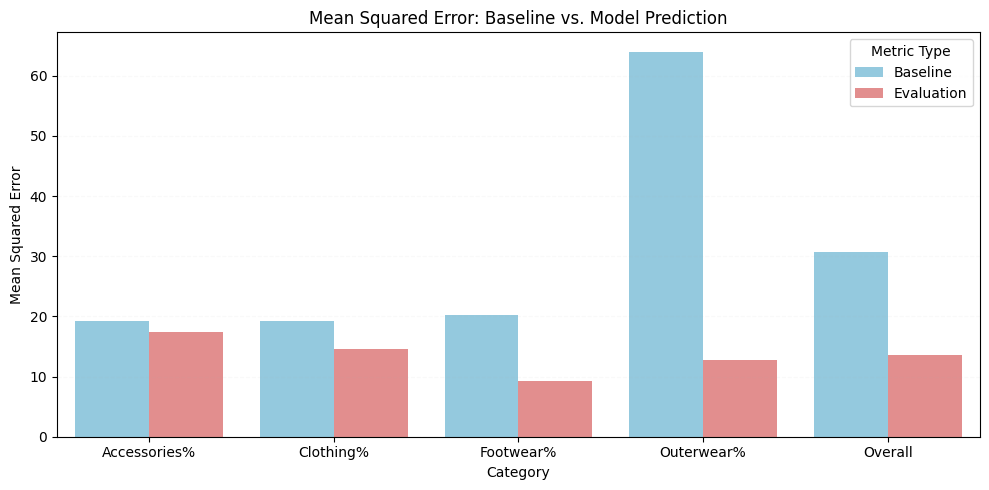

In [29]:
#make a dataframe to make a comparison bar chart from
baseline_metrics_df['Type'] = 'Baseline'
prediction_metrics_df['Type'] = 'Evaluation'

compare_metrics_df = pd.concat([baseline_metrics_df, prediction_metrics_df])

plt.figure(figsize=(10,5))
sns.barplot(
    x = 'Category',
    y = 'MSE',
    hue = 'Type',
    data = compare_metrics_df,
    palette = {'Baseline': 'skyblue', 'Evaluation': 'lightcoral'}
)

plt.title('Mean Squared Error: Baseline vs. Model Prediction')
plt.xlabel('Category')
plt.ylabel('Mean Squared Error')
#plt.xticks(rotation = 45, ha = 'right')
plt.legend(title = 'Metric Type')
plt.tight_layout()
plt.grid(axis = 'y', linestyle = '--', alpha = .07)
plt.show()

Comparison Bar Chart showing the MSE of the training data and the predicted data.  
The lower MSE of the model's evaluation indicates the model is a better predictor than a simple baseline average, especially in the case of outerwear.

## User Interface

#### User Interface Background Code
* Input: Month/Season of future year? Request for lowest performing season/months?
* Output: Catalog Category Breakdown by % recommendation  
  * Show pie chart

In [30]:
#map months to season for predictions
month_to_season_map = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}
season_to_months_map = {
    'Winter': [12, 1, 2],
    'Spring': [3,4,5],
    'Summer': [6,7,8],
    'Fall': [9,10,11]
}


In [37]:
def get_months_in_season():
  while True:
    requested_season = input("Please choose a season to to determine category ratios:\n (Summer, Winter, Fall, Spring): ")
    #match the input case to dict case
    requested_season_normalize = requested_season.title()
    print(f"Predicting Catalog Mix for {requested_season_normalize}")
    #convert season to month
    if requested_season_normalize in season_to_months_map:
      months_in_season = season_to_months_map[requested_season_normalize]
      return months_in_season
    else:
      print(f"Sorry, {requested_season} is not a valid season. Please choose Winter, Spring, Summer, or Fall.")

In [32]:
#make a single dataframe to predict
#input year, season

def request_prediction():
  #requested_year = input("Please enter a year to predict: ")
  requested_year = 2025 #hardcoded for current year
  requested_season = get_months_in_season()
  #make predictions of each of the 3 months
  prediction_data_rows = []
  for month in requested_season:
    prediction_data_rows.append({
        'Year': requested_year,
        'Month': month
    })

  #predict
  prediction_data = pd.DataFrame(prediction_data_rows)
  new_prediction = model_pipeline_reg.predict(prediction_data)

  #average the monthly predictions to create the seasonal prediction
    #convert the list to a numpy array
  avg_predicted_ratio = np.mean(new_prediction, axis=0)

  #convert the array to a dataframe and print for user viewing
  row_labels = ['Accessories', 'Clothing', 'Footwear', 'Outerwear']
  seasonal_prediction_df = pd.DataFrame(avg_predicted_ratio, columns=['Percent'], index=row_labels)
  print(seasonal_prediction_df)

  seasonal_prediction_df.plot.pie(
      y='Percent',
      figsize=(10,10),
      autopct='%1.1f%%',
      startangle=90,
      legend=False,
      title='Predicted Catalog Mix by Category'
  )

  return seasonal_prediction_df


#START HERE (User Interface)

In [ ]:
seasonal_prediction = request_prediction()